In [1]:
using CLOUD
using OrdinaryDiffEq
using LinearAlgebra
using TimerOutputs

In [2]:
L = 2.0  # domain length
T = 10.0  # end time
initial_data = InitialDataGassner()
source_term = SourceTermGassner()
exact_solution = BurgersSolution(initial_data,source_term)
numerical_flux = burgers_lax_friedrichs_flux(1.0)
conservation_law = burgers_equation(source_term, numerical_flux);
tol = 1.0e-8
dt_scale=0.01;

Coarse grid

In [3]:
M = 4  # number of elements
p = 3  # degree of discretization
results_path = string("../results/burgers_source_dgsem_1D_linear_test_M",
    M, "_p", p, "/")
reference_approximation = ReferenceApproximation(
    DGSEM(p), Line(), N_plot=20)
spatial_discretization = SpatialDiscretization(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    (0.0,L), M), reference_approximation)
form = WeakConservationForm()
strategy = Lazy()
solver = Solver(conservation_law, spatial_discretization, form, strategy)
results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, 
     (0.0, T), strategy, results_path, overwrite=true, clear=true);

In [4]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)

n_s = prod(get_dof(spatial_discretization,conservation_law))
r = n_s - 2
dmd_analysis = DMDAnalysis(results_path, conservation_law, 
    spatial_discretization, r=r, tol=tol)
plotter = Plotter(spatial_discretization, string(results_path,"plots/"));

In [5]:
dt = dt_scale*(L/M)/(2*p+1)
n_t = floor(Int, T/dt)
u0 = initialize(initial_data, conservation_law, spatial_discretization)
ode_problem = semidiscretize(solver, u0, (0.0, T))
save_solution(u0, 0.0, results_path, 0)
sol = solve(ode_problem, Tsit5(), adaptive=false, 
    dt=T/n_t, save_everystep=false,
    callback=save_callback(results_path, floor(Int, n_t/(n_s-1))))
save_solution(last(sol.u), last(sol.t), results_path, "final");
plotter = Plotter(spatial_discretization, results_path)
save_solution(last(sol.u), last(sol.t), results_path, "final");

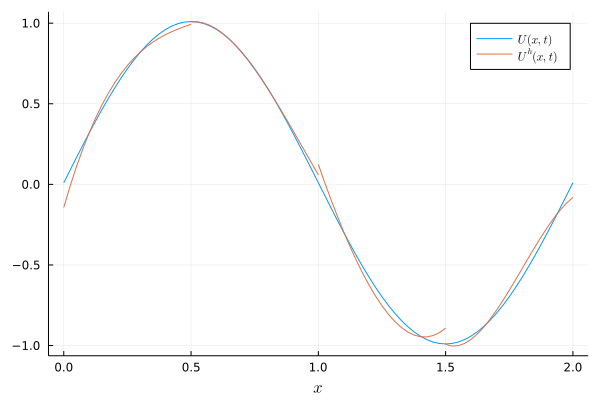

In [6]:
visualize(last(sol.u), plotter, "solution.pdf", exact_solution=exact_solution,
    label="U^h(x,t)", label_exact="U(x,t)", t=T)

L2 error: [0.058724023592773074]


Conservation (initial/final/diff):


[0.01999999999999974][0.020000000000001905][2.1649348980190553e-15]


Energy (initial/final/diff):
[1.0002000000000006][1.0005803208576673][0.000380320857666705]


Max amplification: (1.0001753510137799, 1)


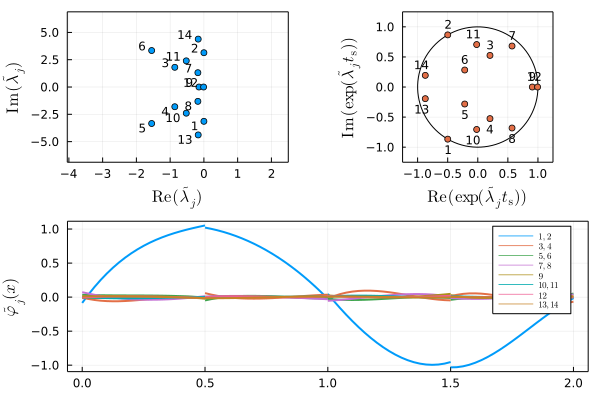

In [7]:
println("L2 error: ", analyze(error_analysis, last(sol.u), initial_data))
println("Conservation (initial/final/diff):\n", analyze(conservation_analysis)...)
println("Energy (initial/final/diff):\n",analyze(energy_analysis)...)
dmd_results = analyze(dmd_analysis)
println("Max amplification: ", findmax(abs.(dmd_results.σ)))
plot_analysis(dmd_analysis, dmd_results, i=1)

Fine Grid

In [8]:
M = 20  # number of elements
p = 3  # degree of discretization
results_path = string("../results/burgers_source_dgsem_1D_linear_test_M",
    M, "_p", p, "/")
reference_approximation = ReferenceApproximation(
    DGSEM(p), Line(), N_plot=20)
spatial_discretization = SpatialDiscretization(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    (0.0,L), M), reference_approximation)
form = WeakConservationForm()
strategy = Lazy()
solver = Solver(conservation_law, spatial_discretization, form, strategy)
results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, 
     (0.0, T), strategy, results_path, overwrite=true, clear=true);

In [9]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)

n_s = prod(get_dof(spatial_discretization,conservation_law))
r = n_s - 2
dmd_analysis = DMDAnalysis(results_path, conservation_law, 
    spatial_discretization, r=r, tol=tol)
plotter = Plotter(spatial_discretization, string(results_path,"plots/"));

In [10]:
dt = dt_scale*(L/M)/(2*p+1)
n_t = floor(Int, T/dt)
u0 = initialize(initial_data, conservation_law, spatial_discretization)
ode_problem = semidiscretize(solver, u0, (0.0, T))
save_solution(u0, 0.0, results_path, 0)
sol = solve(ode_problem, Tsit5(), adaptive=false, 
    dt=T/n_t, save_everystep=false,
    callback=save_callback(results_path, floor(Int, n_t/(n_s-1))))
save_solution(last(sol.u), last(sol.t), results_path, "final");
plotter = Plotter(spatial_discretization, results_path)
save_solution(last(sol.u), last(sol.t), results_path, "final");

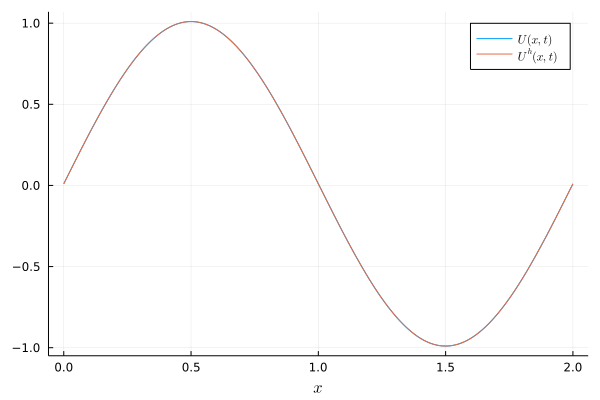

In [11]:
visualize(last(sol.u), plotter, "solution.pdf", exact_solution=exact_solution,
    label="U^h(x,t)", label_exact="U(x,t)", t=T)

L2 error: [0.000283340715504158]
Conservation (initial/final/diff):
[0.019999999999999248][0.01999999999999933][8.326672684688674e-17]
Energy (initial/final/diff):
[1.0002000000000015][1.0001989214869194][-1.0785130821755473e-6]
Max amplification:
(1.2141794159372932, 19)


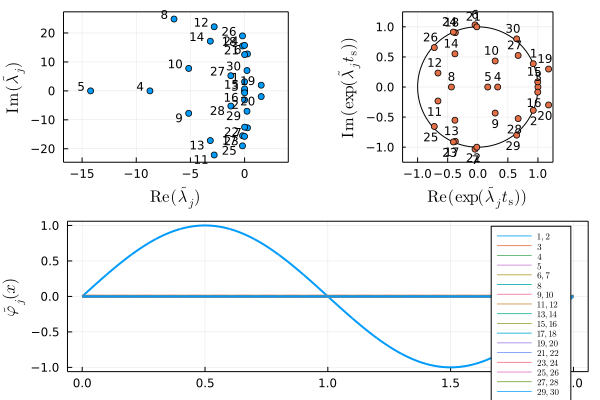

In [15]:
println("L2 error: ", analyze(error_analysis, last(sol.u), initial_data))
println("Conservation (initial/final/diff):\n", analyze(conservation_analysis)...)
println("Energy (initial/final/diff):\n",analyze(energy_analysis)...)
dmd_results = analyze(dmd_analysis)
println("Max amplification:\n", findmax(abs.(dmd_results.σ)))
plot_analysis(dmd_analysis, dmd_results, i=1)